In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'
datadir = "/home/cfs/mer49/gp/"

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# This code benefits considerably from using single-precision floating point
# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

# Set constants

In [2]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128+64    # Grid size
T      = L*L       # Total number of basis functions 
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

In [3]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float32')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Load all datasets from this day
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

# Which datasets to process? 
do_datasets = [1]#range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y     = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta   = np0.max([maxx-minx,maxy-miny])
scale   = (1-1e-6)/(delta*pad*2)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm per bin',cm_p_bin)

# Load a given dataset, rescaling the spatial locations
def load_dataset(fn,dataindex):
    # Get dataset
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

cm per bin 2.112141568754292


P= 12.52


Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

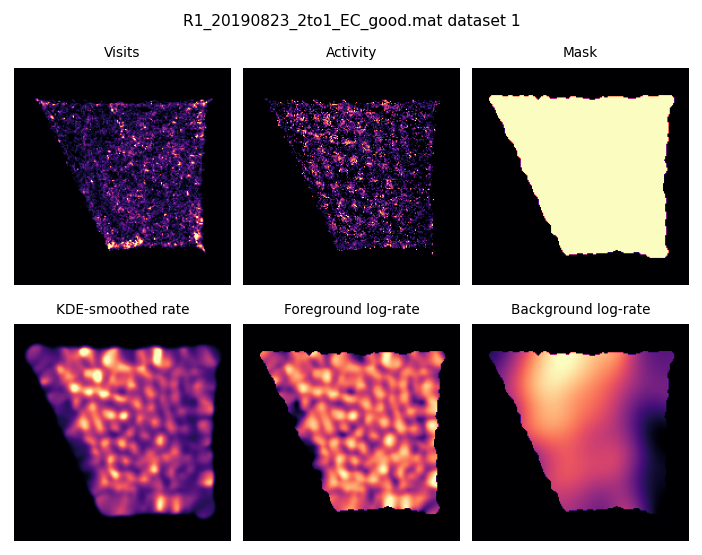

In [4]:
# Get specific dataset
idata = do_datasets[0]
s,x,y,scale = load_dataset(datadir+dataset,idata)

# Grab spikes
st    = find(s>0)
xs,ys = x[st],y[st]
sk    = s[st]
N,K   = bin_spikes(x,y,s,bins)
y1    = nan_to_num(K/N)
mask  = blur(N>0,2)>0.1

# Calibrate grid scale
λhat   = nan_to_num(K/N)
u      = outer(hanning(L),hanning(L))
acorr2 = fft_acorr(λhat*u,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins    

print('P=',P)
fgσ  = P/pi
bgσ  = fgσ*5
λhat = kdeλ(N,K,fgσ)
λbg  = kdeλ(N,K,bgσ)

# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
λhat = kdeλ(N,K,fgσ)           # KDE estimated rate
λbg  = kdeλ(N,K,bgσ)           # Background rate
lλh  = slog(λhat)              # Log rate
lλb  = slog(λbg)               # Log background
lλf  = lλh - lλb               # Foreground log rate

# Initial guess for kernel height
σ0   = zerolag(radial_acorr(lλf,mask))

figure(figsize=(5,4))
subplot(231)
showim(N,'Visits');
subplot(232)
showim(y1,'Activity');
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
showim(λhat,'KDE-smoothed rate');
subplot(235)
showim(lλf,'Foreground log-rate',mask=mask);
subplot(236)
showim(lλb,'Background log-rate',mask=mask);
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

# Define hyperparameter search grid

- β is the kernel height
- P is the kernel period

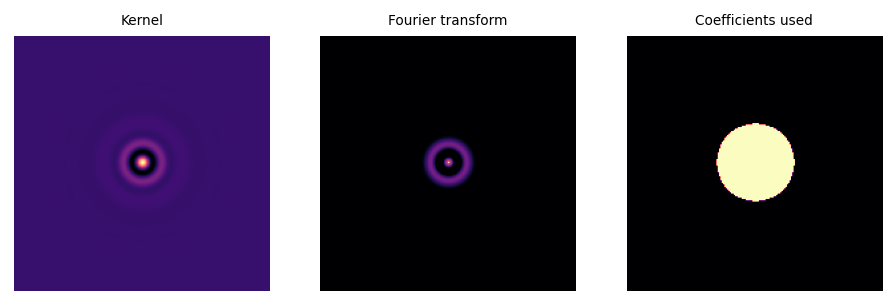

In [5]:
rP   = 2
rβ   = 10
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 11
Nβ   = 11
Ps   = float32(exp(linspace(log(P_lo),log(P_hi),NP)))
βs   = float32(exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1])

@cache(NP*2)
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])/2
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d   = use2d | use2d.T    # Ensure symmetric
use     = find(use2d.ravel()) # Indecies into LxL array to use4
R        = len(use)            # Number of components used
down     = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
f1De   = fft(eye(L),norm='ortho')[use1d,:] # 1D Fourier components used
f1De   = complex64(f1De)
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

def reverse(A):
    # Exchange positive and negative frequencies in a 2D fourier transform
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)

# Positive/negative frequency flip in reduced representation
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())

def er(a,b): print(max(abs(a-b)))
def hcv(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh = kh/2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[use]
def Fv(v):
    #return fhtv(zeros(T).at[use].set(v))
    x = zeros(T)
    x[use] = v
    return x
def fhtv(v):
    v = fft2(v.reshape(L,L),norm='ortho').ravel()
    return v.real+v.imag
def fhtA(x):
    x = fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T)
    return x.real+x.imag
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[use,:]
def FA(A): 
    # Syntax for jax
    # return fhtA(zeros((T,A.shape[-1])).at[use,:].set(A).T).T
    X = zeros((T,A.shape[-1]))
    X[use,:] = A
    return fhtA(X.T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return numpy.linalg.cholesky(x)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])
def logdet(A):
    return sum(slog(diag(chol(A))))*2
    
# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
@cache(NP*2)
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = (Kf.real+Kf.imag).ravel()[use]
    Λh = (Λf.real+Λf.imag).ravel()[use]
    sK = sum(log(Kf[use2d]))
    nK = sum(use2d)
    Λr = hcm(Λh,eye(R))
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = map(float32,[K0,Kf,Λf,Kh,Λh,sK,nK,Λr])
    return K0,Kf,Λf,Kh,Λh,sK,nK,Λr

K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(P)
subplot(131)
showkn(K0,'Kernel')
subplot(132)
showkn(Kf,'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

# Double check Hartley transform

- Kernels are Hermitian; Hartley transform is the Fourier transform

/home/cfs/mer49/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


2.0046163244913373e-06


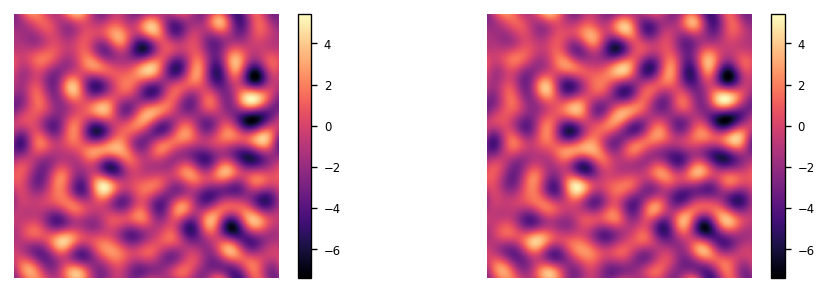

In [6]:
K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)

x  = randn(L,L)
xf = fft2(x,norm='ortho')[use2d].ravel()
xh = xf.real + xf.imag
ch = xh*Kh
c  = zeros((L,L))
c[use2d] = ch
c  = fft2(c,norm='ortho')
c  = c.real + c.imag

subplot(121)
imshow(c.reshape(L,L))
axis('off')
colorbar()
subplot(122)

#c2 = ifft2(Kf*fft2(x)).real

xf = fft2(x)[use2d]
ch = xf*fft2(K0)[use2d]
c2 = zeros((L,L))
c2[use2d] = ch
c2 = ifft2(c2).real

f1 = fft2(x)[use2d]
f2 = fft2(K0)[use2d].real
f3 = f1*f2
c2 = zeros((L,L),dtype='complex64')
c2[use2d] = f3
c2 = ifft2(c2).real

imshow(c2)
axis('off')
colorbar()

print(np.max(abs(c-c2)))

# Check Choleskey inverse

In [7]:
def chinv(X):
    '''
    Q  = float64(randn(100,100))
    Q  = Q@Q.T
    i1 = inv(Q)
    i2 = chinv(Q)
    i2 = i2.T@i2
    np.max(abs(i1-i2))
    '''
    X = float64(X)
    X = scipy.linalg.cholesky(X,lower=True)
    X,info = scipy.linalg.lapack.dtrtri(X,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return X

Q  = float64(randn(100,100))
Q  = Q@Q.T
i1 = inv(Q)
i2 = chinv(Q)
i2 = i2.T@i2
np.max(abs(i1-i2))

1.071587263368201e-12

# Check that low-rank inverse is correct 

We can't actually compute this easily.

In [8]:
# Streamline precomputation of low-rank collapse of diagonal matrix
f1e = fft(eye(L),norm='ortho')[use1d,:]
f2e = f1e[:,None,:,None]*f1e[None,:,None,:]
h2e = f2e.real + f2e.imag
h2e = h2e.reshape(R1d*R1d,L*L)[usecut]
# print('Looks semi-orthoginal:',allclose(eye(R), h2e@h2e.T))

β   = 1.0
μ   = lλf.ravel()
μ0  = lλb.ravel()
v   = 0.*μ+randn(T)*1e-6
λ   = exp(μ + μ0 + v/2)
nλ  = n*λ
x   = sqrt(nλ)
x   = x[None,:]*h2e
xxt = x@x.T

'''
Check that this agrees with other ways of comput F𝔻[nλ]F'
(it does)
other = FtA(FtA(diag(nλ)).T).T
print(np.max(abs(other-xxt)))
q = FtA(diag(sqrt(nλ)))
qqt = q@q.T
print(np.max(abs(qqt-xxt)))
'''

'''
Sanity check the prior kernel
print(np.max(abs(hcm(Λh,eye(R))-diag(Λh))))
'''

Λp  = β*diag(Λh) + xxt
Cp  = chinv(Λp)
Σp  = Cp.T @ Cp

'''
Sanity check Choleskey inverse
print(allclose(eye(R),Σp@Λp))
'''

def fast_low_rank_covariance(nλ,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    x   = sqrt(nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    Cp  = chinv(Λp)
    Σp  = Cp.T @ Cp
    return Σp
    
def fast_covariance_diagonal(nλ,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    x   = sqrt(nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    A   = chinv(Λp)
    # Need to unpack this on the left
    X  = zeros((R,T))
    X[:,use] = A
    A  = X.reshape(R,L,L)
    DF = fft2(A,norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(R,T)
    return sum(DF**2,0)

# Double check that loss is correct 

In [9]:
def logdet(A):
    return sum(log(diag(scipy.linalg.cholesky(A,lower=True))))*2

def loss(μ,v,β,p):
    '''
    n' [ λ - y∘μ ] + ½ μ' Λ₀ μ  + ½ ln|Σ₀| - ½ ln |Σ| + ½ tr[Λ₀ Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    Σr  = fast_low_rank_covariance(nλ,β,p)
    βΛΣ = β*Λr@Σr
    l1  = n@(λ-y*μ)
    l2  = μ@cv(Λf,μ)/2
    l3  = -logdet(β*Λr)/2
    l4  = -logdet(Σr)/2
    l5  = trace(βΛΣ)/2
    return (l1/T,l2/T,l3/T,l4/T,l5/T)

def loss_lowrank(μ,v,β,p):
    '''
    n' [ λ - y∘μ ] + ½ μ' Λ₀ μ  + ½ ln|Σ₀| - ½ ln |Σ| + ½ tr[Λ₀ Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    
    # Send μ to low-rank space
    μ   = ifft2(fft2(μ.reshape(L,L))*use2d).ravel().real
    
    λ   = exp(μ + μ0 + v/2)
    nλ  = n*λ
    Σr  = fast_low_rank_covariance(nλ,β,p)
    βΛΣ = β*Λr@Σr
    
    l1  = n@(λ-y*μ)
    l2  = μ@cv(Λf,μ)/2
    l3  = -logdet(β*Λr)/2
    l4  = -logdet(Σr)/2
    l5  = trace(βΛΣ)/2
    return (l1/T,l2/T,l3/T,l4/T,l5/T)

l1,l2,l3,l4,l5 = loss(μ,v,β,p)
print(l1,l2,l3,l4,l5)
print(sum(array([l1,l2,l3,l4,l5])))

q1,q2,q3,q4,q5 = loss_lowrank(μ,v,β,p)
print(q1,q2,q3,q4,q5)
print(sum(array([q1,q2,q3,q4,q5])))

0.6442412021200555 20707.919154655472 -0.2150655190149943 0.22117779699538456 0.03413647717292599
20708.603644612747
0.6731119461080868 19349.800291111067 -0.2150655190149943 0.22125226654181918 0.03411169327290793
19350.513701497974


# We operate in a low-rank subspace

True


(-0.5, 191.5, -0.5, 191.5)

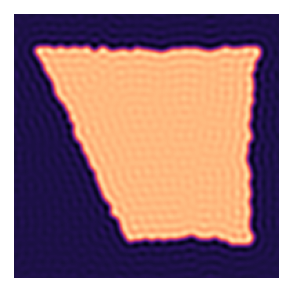

In [10]:
def down(u):
    u = fft2(u.reshape(L,L),norm='ortho')[use2d]
    return u.real + u.imag
def up(u):
    x = zeros((L,L))
    x[use2d] = u
    x = fft2(x,norm='ortho').ravel()
    return x.real + x.imag
x = randn(T)
x = up(down(x))
print(allclose(up(down(x)),x))
imshow(up(down(mask)).reshape(L,L))
axis('off')

# Check simplified Hartley space convolution 

3.552713678800501e-15


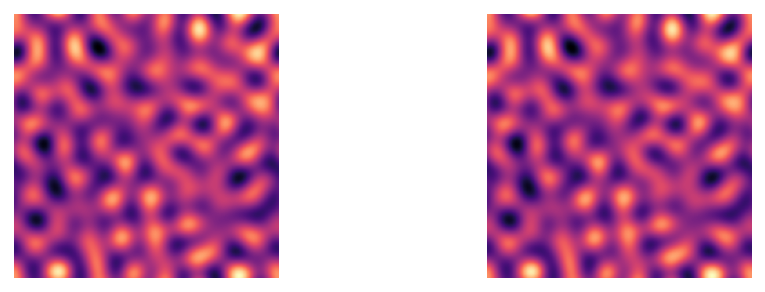

In [11]:
x = randn(L,L)
K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)

x1 = ifft2(Kf*use2d*fft2(x)).real
subplot(121)
imshow(x1)
axis('off')

# With Hartley
a  = fft2(x,norm='ortho')[use2d]
a  = a.imag + a.real
a  = a*Kh
b  = zeros((L,L))
b[use2d] = a
x2 = fft2(b,norm='ortho')
x2 = x2.real + x2.imag
subplot(122)
imshow(x2)
axis('off')

print(np.max(abs(x1-x2)))

# Redo inference 

In [32]:
def fast_covariance_diagonal(nλ,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    x   = sqrt(nλ)
    x   = x[None,:]*h2e
    xxt = x@x.T
    Λp  = β*diag(Λh) + xxt
    A   = chinv(Λp)
    '''
    # Need to unpack this on the left
    X  = zeros((R,T))
    X[:,use] = A
    A  = X.reshape(R,L,L)
    DF = fft2(A,norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(R,T)
    '''
    
    X  = zeros((L,L,R))
    X[use2d] = A.T
    DF = fft2(X,axes=(0,1),norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(T,R).T
    
    return sum(DF**2,0)

def infer(μ,v,β,p,maxiter=100,showprogress=True):
    β = float(β)
    p = float(p)
    report = print if showprogress else lambda *x:()
    
    report('(initializing)')
    
    # Prepare kernel
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    Kβ = Kh/β
    Λβ = Λh*β

    # Preconditioner, in low-rank space
    M = op(R,lambda u:Kβ*u)
    
    # Send everything down into the low-rank space
    μh   = down(μ)
    vh   = down(v)
    μ0h  = down(μ0)
    
    report('(getting variance)')
    
    # Calculate rate with variance correction
    nλ   = n*exp(μ + μ0 + v/2)
    v    = fast_covariance_diagonal(nλ,β,p)
    
    report('(optimizing)')
    
    # Interleave mean and variance iterations
    for i in range(maxiter):
        
        # Inner loop optimizes the mean
        for j in range(maxiter):

            # Gradient, in low-rank space
            μ    = up(μh)
            λ    = exp(μ + μ0 + v/2)
            nλ   = n*λ
            J    = Λβ*μh + down(n*(λ-y))

            # Hessian, in low-rank space
            def Hu(u):
                return Λβ*u + down(nλ*up(u))

            Δμ = minres(op(R,Hu),J,tol=mintol,M=M)[0]
            μh -= Δμ
            if max(abs(Δμ))<tol: break
            report('μ',max(abs(Δμ)),'iteration',i,j)
            
        # Update the variance estimate
        report('(getting variance)')
        # Calculate rate with variance correction
        μ   = up(μh)
        nλ  = n*exp(μ + μ0 + v/2)
        v2  = fast_covariance_diagonal(nλ,β,p)
        Δv  = v2-v
        v   = v2
        
        report('Iteration',i)
        report('Δv',max(abs(Δv)))
        report('Δμ',max(abs(Δμ)))
        if max(abs(Δμ))<tol and max(abs(Δv))<tol: break

    l = concatenate([loss_lowrank(μ,v,β,p), loss(μ,v,β,p)])
    return μ,v,l

In [20]:
#%load_ext snakeviz
#%snakeviz 
v = μ*0
β = 1
tic()
μ,v,l = infer(μ,v,β,P)
tic('took')

(initializing)
(getting variance)
(optimizing)
μ 23.194752103305195 iteration 0 0
μ 1.958003633066669 iteration 0 1
μ 0.021446345059571405 iteration 0 2
(getting variance)
Iteration 0
Δv 0.01341066585728426
Δμ 1.0814040370425691e-05
μ 0.06563177302866133 iteration 1 0
(getting variance)
Iteration 1
Δv 7.529818367254387e-05
Δμ 2.3134962591116397e-05
Δt = 34279 ms elapsed for took


34279.5732421875

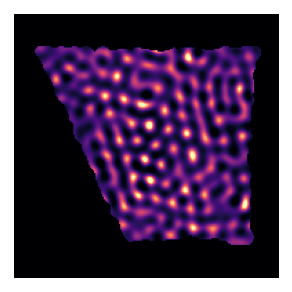

In [21]:
showim(exp((μ+v/2).reshape(L,L)),mask=mask)

# Sweep β and optimize 

In [22]:
# For jupyter notebooks: trigger browser to notify when done
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    #clear_output(False)
def notify(what='attention'):
    #os.system("echo -n '\a'")
    speak(what+'!')

In [23]:
results = []
for i,β in enumerate(βs):
    μ,v,l = infer(μ,v,β,P)
    results += [(μ,v,l)]
notify('DONE')

(initializing)
(getting variance)
(optimizing)
μ 16.298845277484233 iteration 0 0
μ 2.1708084112687085 iteration 0 1
μ 0.01685693592246877 iteration 0 2
(getting variance)
Iteration 0
Δv 0.0013525192676890514
Δμ 1.4165968177756638e-06
μ 0.003878501722312079 iteration 1 0
(getting variance)
Iteration 1
Δv 9.795485861451708e-07
Δμ 2.4203748647255397e-07
(initializing)
(getting variance)
(optimizing)
μ 2.00498003559202 iteration 0 0
μ 0.13598577712277862 iteration 0 1
(getting variance)
Iteration 0
Δv 0.0005060024182687722
Δμ 8.200427305110288e-05
μ 0.0012550012023780652 iteration 1 0
(getting variance)
Iteration 1
Δv 5.186717772429073e-07
Δμ 6.780203170935741e-08
(initializing)
(getting variance)
(optimizing)
μ 2.4582401579705824 iteration 0 0
μ 0.13868724793611292 iteration 0 1
(getting variance)
Iteration 0
Δv 0.0007794523680999012
Δμ 8.568533783184945e-05
μ 0.0031262391390008415 iteration 1 0
(getting variance)
Iteration 1
Δv 1.0926274183215706e-06
Δμ 2.0275522338984462e-07
(initializ

<IPython.core.display.Javascript object>

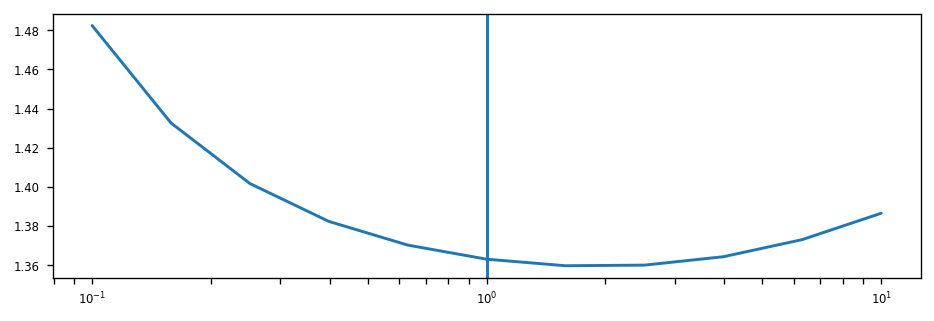

In [30]:
l = array([r[2] for r in results])
plot(βs,sum(l,1))
semilogx()
axvline(1)

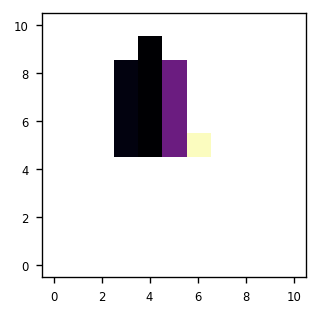

P[7]=16.52 β[4]=1.58


<IPython.core.display.Javascript object>

In [35]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,v,l = infer(μ,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,vref = μ,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else np.sum(array(r[2])) for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]  
def search(ip,iβ,suggested_direction=None):
    global results
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return

    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,v = results[ip-1,iβ][:2]
    else: μ,v = μref,vref
    
    β = βs[iβ]
    μ,v,l = infer(μ,v,float(β),float(p))
    results[ip,iβ] = (μ,v,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],np.sum(array(l))))
    clear_output(wait=True)
    figure()
    imshow(array([sum(array(r[2])) if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    
    # Recursively search nearby
    search_directions = {(0,1),(0,-1),(1,0),(-1,0)}
    # Continue along previous trajectory, if any
    if not suggested_direction is None:
        Δp,Δβ = suggested_direction
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
        search_directions -= {(Δp,Δβ)}
    # Try other trajectories
    for Δp,Δβ in search_directions:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ,suggested_direction=(Δp,Δβ))
    return

ip = NP//2
iβ = Nβ//2
search(ip,iβ)

notify('DONE')

Optimized kernel height β=1.584893
Optimized kernel period P=18.976772


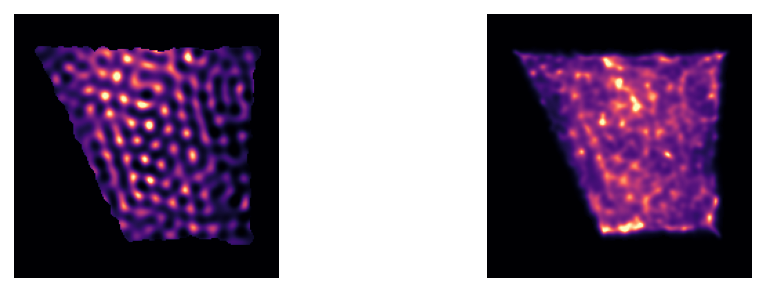

In [36]:
bestP, bestβ = current_best()[:2]
μ,v,l = results[bestP,bestβ]
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

In [38]:
Ps[bestP]

18.976772

In [39]:
βs[bestβ]

1.5848932

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))